## Custom automatic differentiation

In `Qiboml` we inherit the `backend` mechanism introduced in `Qibo`, extending it to the possibility of executing our quantum circuits on a specific engine indipendently of the choice of the high-level interface. 

This means you can decide to work with TensorFlow, or Pytorch, or others, depending on your personal preference, while keeping the possibility to freely set any `Qibo` backend for the circuit's execution.

Moreover, we allow free choice of the differentiation rule to be used, which can be selected among the available differentiation rules implemented in `Qiboml`.

A schematic representation of the pipeline follows, where we use as an example the custom differentiation rule of TensorFlow.
<center><img src="./figures/customdiff.svg" alt="drawing" width="1000"/></center>

In practice, one defines the problem setup by setting the `Qibo` backend as usual. Let's set `tensorflow`.

In [21]:
import os
import time
from copy import deepcopy

# disabling hardware accelerators warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import qibo
from qibo import set_backend
from qibo.backends import construct_backend
from qibo import Circuit, gates, hamiltonians

from qiboml.operations import differentiation, expectation

from importlib import reload
reload(expectation)
reload(differentiation)

<module 'qiboml.operations.differentiation' from '/home/matteo/Documents/PhD/qiboml/src/qiboml/operations/differentiation.py'>

In [22]:
set_backend("tensorflow")

[Qibo 0.2.8|INFO|2024-06-14 12:23:27]: Using tensorflow backend on /device:CPU:0


Now let's setup a simple problem. We build a quantum circuit $U$ composed of some rotations and we compute the gradients of
$$ \langle 0 | U^{\dagger} O U | 0 \rangle, $$
where $O$ is an observable.

Let's start with the circuit:

In [8]:
def build_parametric_circuit(nqubits, nlayers):
    """Build a Parametric Quantum Circuit with Qibo."""
    
    c = Circuit(nqubits)
    for _ in range(nlayers):
        for q in range(nqubits):
            c.add(gates.RY(q=q, theta=0))
            c.add(gates.RZ(q=q, theta=0))
        for q in range(0, nqubits-1, 1):
            c.add(gates.CNOT(q0=q, q1=q+1))
        c.add(gates.CNOT(q0=nqubits-1, q1=0))
    c.add(gates.M(*range(nqubits)))

    return c

In [9]:
# circuit
nqubits = 5
nlayers = 5

c = build_parametric_circuit(nqubits, nlayers)
print(c.draw())

q0:     ─RY─RZ─o───────X─RY─RZ─o───────X─RY─RZ─o───────X─RY─RZ─o───────X─RY─RZ ...
q1:     ─RY─RZ─X─o─────|─RY─RZ─X─o─────|─RY─RZ─X─o─────|─RY─RZ─X─o─────|─RY─RZ ...
q2:     ─RY─RZ───X─o───|─RY─RZ───X─o───|─RY─RZ───X─o───|─RY─RZ───X─o───|─RY─RZ ...
q3:     ─RY─RZ─────X─o─|─RY─RZ─────X─o─|─RY─RZ─────X─o─|─RY─RZ─────X─o─|─RY─RZ ...
q4:     ─RY─RZ───────X─o─RY─RZ───────X─o─RY─RZ───────X─o─RY─RZ───────X─o─RY─RZ ...

q0: ... ─o───────X─M─
q1: ... ─X─o─────|─M─
q2: ... ───X─o───|─M─
q3: ... ─────X─o─|─M─
q4: ... ───────X─o─M─


We can fill the circuit with a set of random parameters

In [10]:
# set random parameters
nparams = len(c.get_parameters())
np.random.seed(42)
params = np.random.uniform(0, 2*np.pi, nparams)

c.set_parameters(params)

We can now define a simple hamiltonian, which will be our target observable.

In [11]:
# an observable
obs = hamiltonians.Z(nqubits=nqubits)

print(type(obs.matrix))

<class 'tensorflow.python.framework.ops.EagerTensor'>


Once executed the circuit, we can use the final state to compute the expectation value of the target observable using the appropriate`Qibo` function. 

In [38]:
# compute the expectation value
final_state = c(nshots=1000).state()

print(obs.expectation(final_state))

tf.Tensor(0.4819699055858453, shape=(), dtype=float64)


On the other hand, we developed a customized version of the `expectation` function in `qiboml`, which allows the user to keep the name convention, while integrating the possibility of customize the automatic differentiation provided by the chosen machine learning framework. It can be called from the `qiboml.expectation` module.

This function accepts some more argument than the `qibo`'s one. In particular:

- `observable`: the target observable, whose expectation value we are interested in;
- `circuit`: the circuit which returns the final state used to compute the expectation value;
- `inital_state`: the state of the system before applying the circuit;
- `nshots`: the number of shots to compute the expectation value;
- `exec_backend`: the backend on which we want to execute the circuit. This backend can even be a real quantum computer, when setting the `qibolab` backend. To construct the backend required here, one can use the method `qibo.backends.construct_backend(backend="backend", platform="platform")`;
- `differentiation_rule`: the actual differentiation rule one wants to apply. 

In [17]:
exec_backend = construct_backend("tensorflow")

exp = expectation.expectation(
    observable=obs,
    circuit=c,
    exec_backend=exec_backend,
    nshots=1000,
)

print(exp)

0.6519999999999999


To check if we are actually changing backend, we can compute a certain number of times the expectation value, and plot the time of execution of different backend engines, such that `tensorflow` or `numpy`.

In [14]:
np_backend = construct_backend("numpy")
tf_backend = construct_backend("tensorflow")

np_times, tf_times = [0.], [0.]
nexec = 2

for n in range(nexec):
    # some logging messages
    if (n%100==0):
        print(f"{n}/{nexec} exec")
    
    # executing on numpy backend
    it = time.time()
    expectation.expectation(
        observable=obs,
        circuit=c,
        exec_backend=np_backend,
        differentiation_rule=differentiation.parameter_shift
    )
    ft = time.time()
    np_times.append((ft-it))

    # executing on tensorflow backend
    it = time.time()
    expectation.expectation(
        observable=obs,
        circuit=c,
        exec_backend=tf_backend,
        differentiation_rule=differentiation.parameter_shift
    )
    ft = time.time()
    tf_times.append((ft-it))

0/2 exec
here
here
here
here


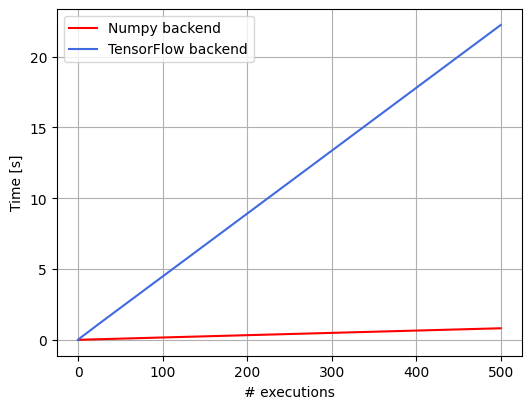

In [20]:
plt.figure(figsize=(6, 6*6/8))
plt.plot(np.add.accumulate(np_times), color="red", label="Numpy backend")
plt.plot(np.add.accumulate(tf_times), color="royalblue", label="TensorFlow backend")
plt.legend()
plt.xlabel("# executions")
plt.ylabel("Time [s]")
plt.grid(True)
plt.savefig("tf_vs_np.png", dpi=1200)
plt.show()

This behaviour is expected, since TensorFlow is typically slower than the Numpy backend in executing circuits. It is clear, here, that setting the backend engine to `numpy`, even setting the `frontend` as `tensorflow`, is more convenient.

### Optimization example

In the following, we optimize the parameters of the parametric circuit to minimize a target cost function, which is the expectation value of a target hamiltonian. We will repeat this three times, using different configuation of the `qiboml` custom differentiation. Let us describe each of these scenarios with the triad `(frontend, differentiation rule, execution backend)`:

1. `(tf, psr, tf)`: we are working with the TensorFlow interface, we use the parameter shift rule as differentiation algorithm and we execute the circuits using the Qibo's `tensorflow` backend;
2. `(tf, psr, np)`: we are working with the TensorFlow interface, we use the parameter shift rule as differentiation algorithm and we execute the circuits using the Qibo's `numpy` backend;
3. `(tf, tf, tf)`: we are working with the TensorFlow interface, we use the tensorflow automatic differentiation algorithm and we execute the circuits using the Qibo's `tensorflow` backend.

Note that these are only three of the many possible combinations. One has to pay attention to the problem configuration, e.g. considering the parameter shift algorithm when executing circuits on real hardware (`qibolab` backend), or activating the shot-noise. In fact, the automatic differentiation of tensorflow breaks when shot-noise is activated.

We make use of the following function, through which we can customize the training.

In [12]:
def train_circuit(circuit, hamiltonian, nepochs, exec_backend, differentiation_rule=None, nshots=None):
    """
    Perform a simple gradient descent training of ``circuit`` to minimize the expectation 
    value of ``hamiltonian``. Gradients are computed via the chosen ``differentiation_rule``
    and expectation values calculated executing circuit on the selected ``exec_backend``.

    Returns: 
        float: total execution time.
    """
    # a couple of hyper-parameters
    learning_rate = 0.01
    random_seed = 42

    # random parameters
    np.random.seed(random_seed)
    nparams = len(circuit.get_parameters())
    params = tf.Variable(np.random.uniform(0, 2*np.pi, nparams))

    it = time.time()

    for epoch in range(nepochs):
        with tf.GradientTape() as tape:
            circuit.set_parameters(params)
            #print(params)
            cost = expectation.expectation(
                    observable=hamiltonian,
                    circuit=circuit,
                    exec_backend=exec_backend,
                    differentiation_rule=differentiation_rule,
                    nshots=nshots,
                )
            if (epoch % 10 == 0):
                print(f"Cost: {round(cost, 4)} \t |\t Epoch: {epoch}")
            gradients = tape.gradient(cost, params)
            init_params = params.assign_sub(learning_rate * gradients)
    ft = time.time()
    
    return (ft - it)  

#### Training scenario 1: `(tf, psr, tf)`

In [17]:
nqubits = 3
nlayers = 3
nepochs = 50

# setup the problem
circuit = build_parametric_circuit(nqubits, nlayers)
hamiltonian = hamiltonians.Z(nqubits)

tf_psr_tf_time = train_circuit(
    circuit=circuit,
    hamiltonian=hamiltonian,
    nepochs=nepochs,
    exec_backend=tf_backend,
    differentiation_rule=differentiation.parameter_shift
)

print(f"Execution time with (tf, psr, tf): {tf_psr_tf_time}")

Cost: 0.3486 	 |	 Epoch: 0
Cost: 0.0435 	 |	 Epoch: 10
Cost: -0.2314 	 |	 Epoch: 20
Cost: -0.457 	 |	 Epoch: 30
Cost: -0.629 	 |	 Epoch: 40
Execution time with (tf, psr, tf): 33.1975154876709


#### Training scenario 2: `(tf, psr, np)`

In [19]:
tf_psr_np_time = train_circuit(
    circuit=circuit,
    hamiltonian=hamiltonian,
    nepochs=nepochs,
    exec_backend=np_backend,
    differentiation_rule=differentiation.parameter_shift
)

print(f"Execution time with (tf, psr, np): {tf_psr_np_time}")

Cost: 0.3486 	 |	 Epoch: 0
Cost: 0.0435 	 |	 Epoch: 10
Cost: -0.2314 	 |	 Epoch: 20
Cost: -0.457 	 |	 Epoch: 30
Cost: -0.629 	 |	 Epoch: 40
Execution time with (tf, psr, np): 1.7887814044952393


#### Training scenario 3: `(tf, tf, tf)`

In [23]:
tf_tf_tf_time = train_circuit(
    circuit=circuit,
    hamiltonian=hamiltonian,
    nepochs=100,
    exec_backend=tf_backend,
    differentiation_rule=None
)

print(f"Execution time with (tf, tf, tf): {tf_tf_tf_time}")

Cost: 0.3486 	 |	 Epoch: 0


TypeError: 'NoneType' object is not callable

In [26]:
print(f"(tf, psr, tf): {tf_psr_tf_time}")
print(f"(tf, psr, np): {tf_psr_np_time}")
print(f"(tf, sym, tf): {tf_tf_tf_time}")

(tf, psr, tf): 455.663761138916
(tf, psr, np): 30.62137269973755
(tf, sym, tf): 15.607949256896973


It is clear in this setup the last configuration is the fastest. This can be explained considering TensorFlow's automatic differentiation routines, which are well optimized to compute the backpropagation algorithm. But if we activate the shot-noise the discussion changes. In fact, the TensorFlow automatic differentiation is not usable in a shot-noise setup, and one of the other options has to be set. In that case, using the `numpy` (or the `) backend